### Load modules

In [1]:
import numpy as np
import math
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle

%matplotlib inline

### Load data

In [2]:
with open('traffic.pickle', 'rb') as pfile:
    data = pickle.load(pfile)
    features = data['features']
    labels = data['labels']
print(features.shape, labels.shape)

(39209, 32, 32, 3) (39209,)


Text(0.5,1,'9')

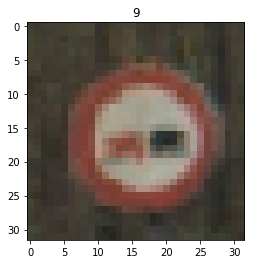

In [3]:
np.random.seed(12)
idx = np.random.randint(0, features.shape[0])
plt.imshow(features[idx])
plt.title(labels[idx])

### Normalize images

In [4]:
features_max = features.max(axis=(1, 2), keepdims=True)
features_min = features.min(axis=(1, 2), keepdims=True)
features = (features - features_min) / (features_max - features_min)

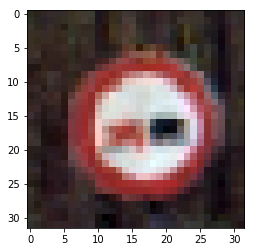

In [5]:
img = features[idx]
plt.imshow(img)

In [6]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(features, labels, test_size=0.1, random_state=0)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=0)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_valid.shape, y_valid.shape)

(28230, 32, 32, 3) (28230,) (7058, 32, 32, 3) (7058,) (3921, 32, 32, 3) (3921,)


In [7]:
n_labels = len(np.unique(labels))
print(n_labels)

43


In [8]:
import tensorflow as tf

def lenet(x):
    # input: 32x32x3, output: 14x14x6
    conv1_w = tf.Variable(tf.truncated_normal((5, 5, 3, 6), stddev=0.1))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1 = tf.nn.conv2d(x, conv1_w, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    conv1 = tf.nn.relu(conv1)
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # input 14x14x6, output: 5x5x16
    conv2_w = tf.Variable(tf.truncated_normal((5, 5, 6, 16), stddev=0.1))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.conv2d(conv1, conv2_w, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    conv2 = tf.nn.relu(conv2)
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # fc 400
    fc0 = tf.contrib.layers.flatten(conv2)
    
    # input:400, output: 120
    fc1_w = tf.Variable(tf.truncated_normal((400, 120), stddev=0.1))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1 = tf.nn.relu(tf.matmul(fc0, fc1_w) + fc1_b)
    fc1 = tf.nn.dropout(fc1, 0.5)
    
    # input:120, output: 84
    fc2_w = tf.Variable(tf.truncated_normal((120, 84), stddev=0.1))
    fc2_b = tf.Variable(tf.zeros(84))
    fc2 = tf.nn.relu(tf.matmul(fc1, fc2_w) + fc2_b)
    fc2 = tf.nn.dropout(fc2, 0.5)
    
    # input: 84, output: n_labels, 43
    fc3_w = tf.Variable(tf.truncated_normal((84, n_labels), stddev=0.1))
    fc3_b = tf.Variable(tf.zeros(n_labels))
    logits = tf.matmul(fc2, fc3_w) + fc3_b
    
    return logits

In [9]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
y_hot = tf.one_hot(y, n_labels)

learning_rate = 0.002
EPOCHS = 50
BATCH_SIZE = 512

In [10]:
logits = lenet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y_hot, logits=logits)
loss = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

In [11]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y_hot, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [12]:
from sklearn.utils import shuffle

saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(x_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        x_train0, y_train0 = shuffle(x_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = x_train0[offset:end], y_train0[offset:end]
            _, l, acc = sess.run([optimizer, loss, accuracy_operation], feed_dict={x: batch_x, y: batch_y})
#             print(l, acc)
            
        validation_accuracy = evaluate(x_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.392

EPOCH 2 ...
Validation Accuracy = 0.580

EPOCH 3 ...
Validation Accuracy = 0.679

EPOCH 4 ...
Validation Accuracy = 0.714

EPOCH 5 ...
Validation Accuracy = 0.762

EPOCH 6 ...
Validation Accuracy = 0.787

EPOCH 7 ...
Validation Accuracy = 0.813

EPOCH 8 ...
Validation Accuracy = 0.829

EPOCH 9 ...
Validation Accuracy = 0.844

EPOCH 10 ...
Validation Accuracy = 0.857

EPOCH 11 ...
Validation Accuracy = 0.847

EPOCH 12 ...
Validation Accuracy = 0.859

EPOCH 13 ...
Validation Accuracy = 0.879

EPOCH 14 ...
Validation Accuracy = 0.879

EPOCH 15 ...
Validation Accuracy = 0.877

EPOCH 16 ...
Validation Accuracy = 0.890

EPOCH 17 ...
Validation Accuracy = 0.903

EPOCH 18 ...
Validation Accuracy = 0.897

EPOCH 19 ...
Validation Accuracy = 0.904

EPOCH 20 ...
Validation Accuracy = 0.901

EPOCH 21 ...
Validation Accuracy = 0.907

EPOCH 22 ...
Validation Accuracy = 0.911

EPOCH 23 ...
Validation Accuracy = 0.909

EPOCH 24 ...
Validation Accura

In [15]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(x_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.939


In [14]:
x_train[0].min()

0.0